In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

C:\ProgramData\Anaconda3\envs\dogspiracy\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\ProgramData\Anaconda3\envs\dogspiracy\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\ProgramData\Anaconda3\envs\dogspiracy\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#s

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset mnist downloaded and prepared to C:\Users\Nerevar\tensorflow_datasets\mnist\1.0.0. Subsequent calls will reuse this data.


In [3]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label

In [4]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 2048

In [5]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [6]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [7]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [8]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [12]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
32/32 [==============================] - 26s 818ms/step - loss: 0.7860 - accuracy: 0.7573 - val_loss: 0.3822 - val_accuracy: 0.8872
Epoch 2/5
32/32 [==============================] - 28s 873ms/step - loss: 0.2199 - accuracy: 0.9375 - val_loss: 0.3442 - val_accuracy: 0.9018
Epoch 3/5
32/32 [==============================] - 25s 776ms/step - loss: 0.1031 - accuracy: 0.9663 - val_loss: 0.3079 - val_accuracy: 0.9126
Epoch 4/5
32/32 [==============================] - 26s 800ms/step - loss: 0.0686 - accuracy: 0.9775 - val_loss: 0.2798 - val_accuracy: 0.9270
Epoch 5/5
32/32 [==============================] - 25s 779ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.2733 - val_accuracy: 0.9341


In [14]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=5, validation_data=validation_batches)

Epoch 1/5
32/32 [==============================] - 25s 790ms/step - loss: 2.2866 - accuracy: 0.3145 - val_loss: 1.1553 - val_accuracy: 0.6398
Epoch 2/5
32/32 [==============================] - 28s 876ms/step - loss: 1.4437 - accuracy: 0.5229 - val_loss: 0.7259 - val_accuracy: 0.7976
Epoch 3/5
32/32 [==============================] - 29s 922ms/step - loss: 1.0028 - accuracy: 0.6685 - val_loss: 0.5125 - val_accuracy: 0.8524
Epoch 4/5
32/32 [==============================] - 28s 885ms/step - loss: 0.8542 - accuracy: 0.7202 - val_loss: 0.4794 - val_accuracy: 0.8474
Epoch 5/5
32/32 [==============================] - 28s 880ms/step - loss: 0.7619 - accuracy: 0.7739 - val_loss: 0.3639 - val_accuracy: 0.8934


(0.75, 1)

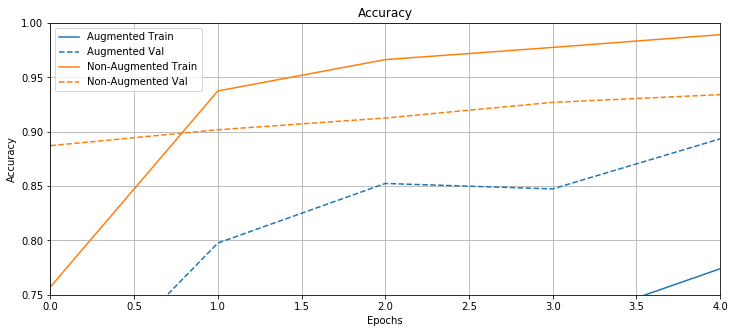

In [15]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

# Image Augmentation 
### Setup
- pillow

### Import der Bibliotheken

In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_datasets as tfds

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np


## Inhaltsverzeichnis
<ol>
    <li><a href="#einleitung">Einleitung</a></li>
    <li><a href="#schluss">Schlussteil</a></li>
    <li><a href="#quellen">Quellenverzeichnis</a></li>
</ol>

## Einleitung <div id="einleitung" />
- Probleme mit zu kleinem Datenset => führte zu Overfitting
- wie man Overfitting erkennt
- welche Maßnahmen es gegen Overfitting gibt

Overfitting bezieht sich auf ein Model, das den Trainingsdatensatz zu gut gelernt hat, einschließlich des statistischen Rauschens oder zufälliger Schwankungen im Trainingsdatensatz.

![test](../assets/overfitting.jpeg)
_Abbildung 1: Beispielkurve für Overfitting aus dem Training für Hunderassenklassifizierung_

## Beispiel Image Augmentation mit Tensorflow

Importieren einen Bildes

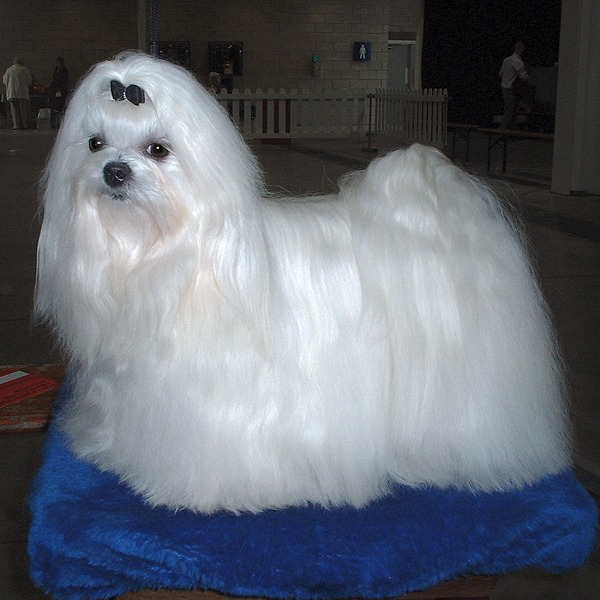

In [2]:
image_path = tf.keras.utils.get_file("good_boy.jpg", "https://raw.githubusercontent.com/MajusLenz/Dogspiracy-machine-learning/master/data/images/predict/good_boy.jpg")
Image.open(image_path)


Das Bild wird in Tensorflow Format konvertiert:

In [3]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)

Über eine Funktion kann das Originalbild mit dem augmentierten Bild verglichen werden:

In [4]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


Das Bild drehen:

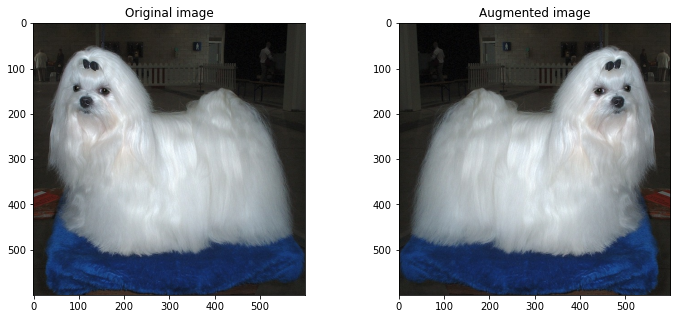

In [5]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

Grayscale

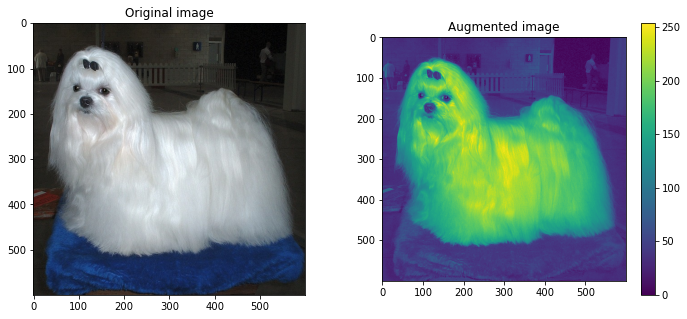

In [6]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

Saturation

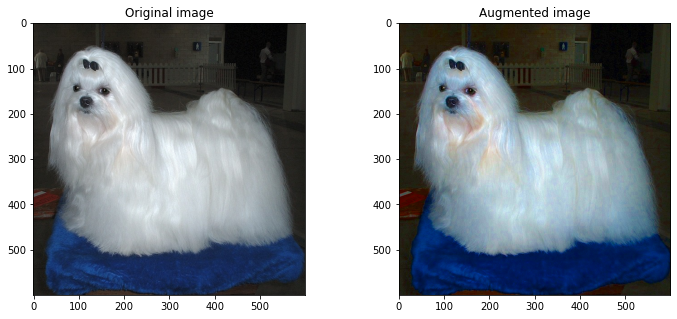

In [7]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)


Helligkeit:

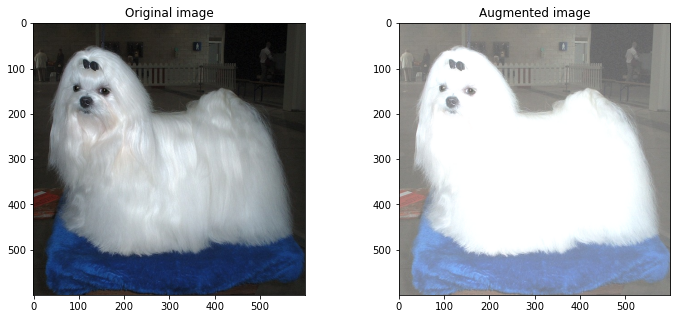

In [8]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

Kontrast:

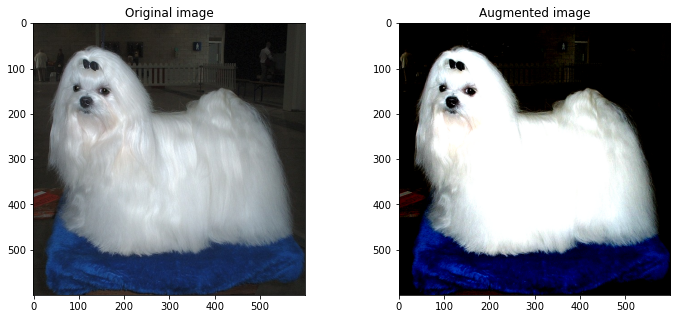

In [9]:
contrast = tf.image.adjust_contrast(image, 2)
visualize(image, contrast)

Rotation

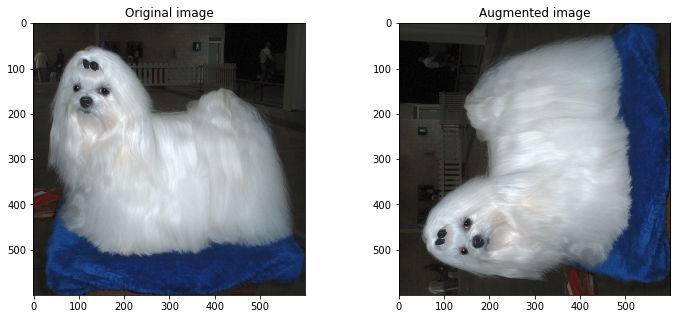

In [10]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Crop

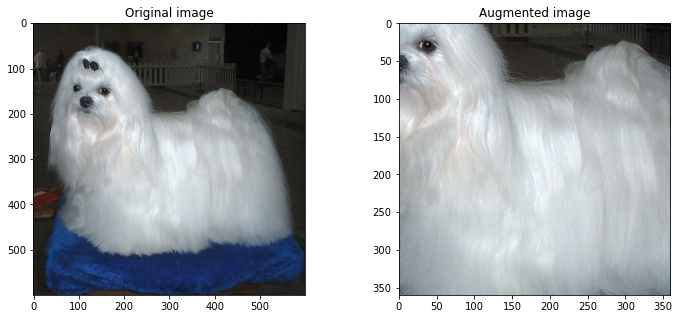

In [11]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
visualize(image,cropped)


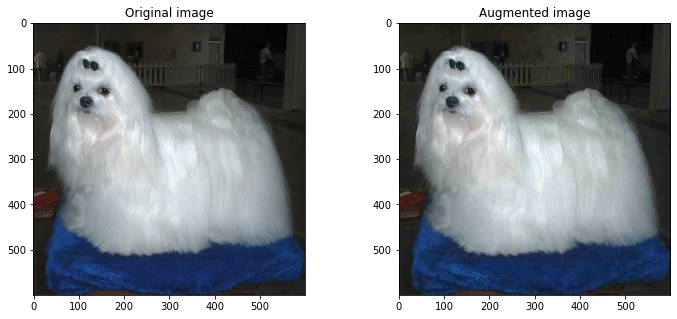

In [12]:
quality = tf.image.adjust_jpeg_quality(image, 20)
visualize(image,quality)

## Training im Vergleich

In [13]:
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    import os
    import pathlib 

    cwd = os.getcwd()
    RAW_DATA_DIR = cwd + '/dog-breeds/'
    CLASS_NAMES = np.array([item.name for item in pathlib.Path(RAW_DATA_DIR).glob('*') if item.name != "LICENSE.txt"])
    NUMBER_OF_CLASSES = len(CLASS_NAMES)
    
    def get_label(file_path):
        # convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)
        result = tf.where(parts[-2] == CLASS_NAMES)
        return result

    def decode_img(img):
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Use `convert_image_dtype` to convert to floats.
        img = tf.image.convert_image_dtype(img, tf.float32)
        # scale image between 0 and 1
        img = img / 255.0
        # resize the image to the desired size.
        return tf.image.resize(img, [224, 224])

    def process_path(file_path):
        print(file_path)
        label = get_label(file_path)
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = decode_img(img)
        return img, label

    def prepare_for_training(ds, shuffle_buffer_size=1000, shuffle=True):
        if shuffle:
            ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat forever
        ds = ds.repeat()

        ds = ds.batch(64)

        # `prefetch` lets the dataset fetch batches in the background while the model
        # is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds


In [14]:
import pathlib 
import os
import math

cwd = os.getcwd()
print(cwd)
list_ds = tf.data.Dataset.list_files(cwd + '/dog-breeds/*/*.jpg')
image_count = len(list( pathlib.Path(RAW_DATA_DIR).glob('*/*.jpg')))

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# load all images
all_ds = prepare_for_training(labeled_ds)
test_percentage = 0.2

n_test_examples = math.floor(test_percentage * image_count)
# how many batches should be considered in one epoch?
STEPS_PER_EPOCH = np.ceil((image_count - n_test_examples) / 64)
# split in test and train dataset
test_dataset = all_ds.take(n_test_examples)
train_dataset = all_ds.skip(n_test_examples)

C:\Users\Jana\Desktop\Dogspiracy-machine-learning\jupyter_notebook
Tensor("args_0:0", shape=(), dtype=string)


### Model

In [15]:
def make_model():
  model = tf.keras.Sequential([
      layers.Conv2D(16, 5, padding="same", activation="relu",
                input_shape=(224, 224, 3)),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(6)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [16]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label

validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*64)
)


In [17]:
non_augmented_train_batches = (
    train_dataset
    .cache()
    .shuffle(200)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
) 

In [18]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)


ValueError: in converted code:

    C:\Users\Jana\anaconda3\envs\dogspiracy\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\Users\Jana\anaconda3\envs\dogspiracy\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\Users\Jana\anaconda3\envs\dogspiracy\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected flatten_input to have 4 dimensions, but got array with shape (None, None, 224, 224, 3)


## Schlussteil <div id="schluss" />

## Quellenverzeichnis <div id="quellen" />
- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://www.tensorflow.org/tutorials/images/data_augmentation